# Ischemic lesion segmentation in the brain

In [1]:
model_name = '2+1D_high_res'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install bids
!pip install git+https://github.com/npnl/bidsio
import bidsio
bids_loader = bidsio.BIDSLoader(data_entities=[{'subject': '',
                                               'session': '',
                                               'suffix': 'T1w',
                                               'space': 'MNI152NLin2009aSym'}],
                                target_entities=[{'suffix': 'mask',
                                                'label': 'L',
                                                'desc': 'T1lesion'}],
                                data_derivatives_names=['ATLAS'],
                                target_derivatives_names=['ATLAS'],
                                batch_size=10,
                                root_dir='/content/drive/MyDrive/ATLASSTUFF/split1/split1/train/')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.9 MB 34.4 MB/s 
     |████████████████████████████████| 68 kB 6.9 MB/s 
     |████████████████████████████████| 1.3 MB 64.1 MB/s 
     |████████████████████████████████| 125 kB 80.4 MB/s 
     |████████████████████████████████| 96 kB 5.9 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=6c6438cc672640213e99191a4b5aa7030118fad09be531050bb023fa53c9054e
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 1.4.45
    Uninstalling SQLAlchemy-1.4.45:
      Successfully uninstalled SQLAlchemy-1.4.45
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: p

In [ ]:
tmp = bids_loader.load_sample(0)
print(f'There are {len(bids_loader)} subjects in our dataset.')
print(f'Every sample loads {len(tmp)} images.')
print(f'Images have these dimensions: {bids_loader.data_shape}')
print(f'Every batch will load {bids_loader.batch_size} samples.')

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, width_multiplier=1, trilinear=True, use_ds_conv=False):
        """A simple 3D Unet, adapted from a 2D Unet from https://github.com/milesial/Pytorch-UNet/tree/master/unet
        Arguments:
          n_channels = number of input channels; 3 for RGB, 1 for grayscale input
          n_classes = number of output channels/classes
          width_multiplier = how much 'wider' your UNet should be compared with a standard UNet
                  default is 1;, meaning 32 -> 64 -> 128 -> 256 -> 512 -> 256 -> 128 -> 64 -> 32
                  higher values increase the number of kernels pay layer, by that factor
          trilinear = use trilinear interpolation to upsample; if false, 3D convtranspose layers will be used instead
          use_ds_conv = if True, we use depthwise-separable convolutional layers. in my experience, this is of little help. This
                  appears to be because with 3D data, the vast vast majority of GPU RAM is the input data/labels, not the params, so little
                  VRAM is saved by using ds_conv, and yet performance suffers."""
        super(UNet, self).__init__()
        _channels = (32, 64, 128, 256, 512)
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.channels = [int(c*width_multiplier) for c in _channels]
        self.trilinear = trilinear
        self.convtype = DepthwiseSeparableConv3d if use_ds_conv else nn.Conv3d

        self.inc = DoubleConv(n_channels, self.channels[0], conv_type=self.convtype)
        self.down1 = Down(self.channels[0], self.channels[1], conv_type=self.convtype)
        self.down2 = Down(self.channels[1], self.channels[2], conv_type=self.convtype)
        self.down3 = Down(self.channels[2], self.channels[3], conv_type=self.convtype)
        factor = 2 if trilinear else 1
        self.down4 = Down(self.channels[3], self.channels[4] // factor, conv_type=self.convtype)
        self.up1 = Up(self.channels[4], self.channels[3] // factor, trilinear)
        self.up2 = Up(self.channels[3], self.channels[2] // factor, trilinear)
        self.up3 = Up(self.channels[2], self.channels[1] // factor, trilinear)
        self.up4 = Up(self.channels[1], self.channels[0], trilinear)
        self.outc = OutConv(self.channels[0], n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        # print(x1.shape)
        x2 = self.down1(x1)
        # print(x2.shape)
        x3 = self.down2(x2)
        # print(x3.shape)
        x4 = self.down3(x3)
        # print(x4.shape)
        x5 = self.down4(x4)
        # print(x5.shape)
        x = self.up1(x5, x4)
        # print("debug")
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, conv_type=nn.Conv3d, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            conv_type(in_channels, mid_channels, kernel_size=(1,3,3), padding=(0,2,1)),
            nn.BatchNorm3d(mid_channels),
            nn.ReLU(inplace=True),
            conv_type(mid_channels, out_channels, kernel_size=(3,3,1), padding=(1,0,0)),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels, conv_type=nn.Conv3d):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool3d(2),
            DoubleConv(in_channels, out_channels, conv_type=conv_type)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()

        # if trilinear, use the normal convolutions to reduce the number of channels
        if trilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, mid_channels=in_channels // 2)
        else:
            self.up = nn.ConvTranspose3d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class DepthwiseSeparableConv3d(nn.Module):
    def __init__(self, nin, nout, kernel_size, padding, kernels_per_layer=1):
        super(DepthwiseSeparableConv3d, self).__init__()
        self.depthwise = nn.Conv3d(nin, nin * kernels_per_layer, kernel_size=kernel_size, padding=padding, groups=nin)
        self.pointwise = nn.Conv3d(nin * kernels_per_layer, nout, kernel_size=1)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

model = UNet(n_channels=1, n_classes=1)

In [ ]:
# model.load_state_dict(torch.load('drive/MyDrive/big_brain/models/'+model_name+'/model_weights_'+model_name+'.pth'))

In [5]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [6]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

loss_func = DiceBCELoss()

In [ ]:
import torchvision.transforms as T

def downsize_64(batch):
  if (len(batch.shape) == 4):
    batch = batch.unsqueeze(0)
  num_samples = batch.shape[0]
  scale = 3
  batch = batch[:,:,::scale,::scale,::scale]
  batch = batch[:,:,:64,:64]
  zeros = torch.zeros(num_samples,1,64,64,1)
  batch = torch.cat((zeros, batch), 4)
  return batch

def downsize_128(batch):
  num_samples = batch.shape[0]
  d = torch.linspace(-1, 1, 128)
  meshz, meshy, meshx = torch.meshgrid((d, d, d))
  grid = torch.stack((meshx, meshy, meshz), 3)
  grid = grid.unsqueeze(0)
  grid = grid.repeat_interleave(num_samples, dim=0)

  return F.grid_sample(batch, grid, align_corners=True)


In [7]:
import random
def cubeView(batch, labels, cubeSize, threshold):
  shape = batch.shape
  x_len = shape[2]
  y_len = shape[3]
  z_len = shape[4]
  resultData = torch.empty((shape[0], shape[1], cubeSize, cubeSize, cubeSize))
  resultLabel = torch.empty((shape[0], shape[1], cubeSize, cubeSize, cubeSize))
  for i in range(shape[0]):
    loopB = True
    while(loopB):
      (posx, posy, posz) = random.randint(0, x_len - cubeSize), random.randint(0, y_len - cubeSize), random.randint(0, z_len - cubeSize)
      if (torch.sum(labels[i,:,posx:posx+cubeSize, posy:posy+cubeSize, posz:posz+cubeSize]) / torch.sum(labels[i,::,::,::,::]) > threshold):
        resultData[i, :, :, :, :] = batch[i,:,posx:posx+cubeSize, posy:posy+cubeSize, posz:posz+cubeSize]
        resultLabel[i, :, :, :, :] = labels[i,:,posx:posx+cubeSize, posy:posy+cubeSize, posz:posz+cubeSize]
        loopB = False
  return resultData, resultLabel

In [ ]:


#model.load_state_dict(torch.load('drive/MyDrive/ATLASSTUFF/model_weights_osu4.pth'))

# model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

losses = []

for epoch in range(40):
    i = 0
    running_loss = 0.0
    for data, label in bids_loader.load_batches():

        data = torch.Tensor(data)
        label = torch.Tensor(label)

        data, label = cubeView(data, label, 64, .3)
        data = data.to(device)
        label = label.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(data)
        loss = loss_func(outputs, label)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i % 10 == 9):
          print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10 :.8f}')
          losses.append(running_loss)
          running_loss = 0.0
        i += 1
        torch.save(model.state_dict(), 'drive/MyDrive/ATLASSTUFF/model_weights_osu4.pth')


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1,    10] loss: 1.25728345
[1,    20] loss: 1.34505601
[1,    30] loss: 1.28022131
[1,    40] loss: 1.27154142
[1,    50] loss: 1.19234041
[2,    10] loss: 1.22888774
[2,    20] loss: 1.32153982
[2,    30] loss: 1.25961783
[2,    40] loss: 1.25055628
[2,    50] loss: 1.18152050
[3,    10] loss: 1.21607047
[3,    20] loss: 1.30699024
[3,    30] loss: 1.24163178
[3,    40] loss: 1.23093369
[3,    50] loss: 1.16452246
[4,    10] loss: 1.18400388
[4,    20] loss: 1.29031485
[4,    30] loss: 1.22129868
[4,    40] loss: 1.20974921
[4,    50] loss: 1.13612080
[5,    10] loss: 1.14890277
[5,    20] loss: 1.27583820
[5,    30] loss: 1.20403584
[5,    40] loss: 1.18404588
[5,    50] loss: 1.12448933
[6,    10] loss: 1.14728860
[6,    20] loss: 1.26289054
[6,    30] loss: 1.18998963
[6,    40] loss: 1.17177759
[6,    50] loss: 1.10755112
[7,    10] loss: 1.13574892
[7,    20] loss: 1.25287108
[7,    30] loss: 1.15830621
[7,    40] loss: 1.15903431
[7,    50] loss: 1.09147574
[8,    10] loss: 1.1

In [ ]:
test_loader = bidsio.BIDSLoader(data_entities=[{'subject': '',
                                               'session': '',
                                               'suffix': 'T1w',
                                               'space': 'MNI152NLin2009aSym'}],
                                target_entities=[{'suffix': 'mask',
                                                'label': 'L',
                                                'desc': 'T1lesion'}],
                                data_derivatives_names=['ATLAS'],
                                target_derivatives_names=['ATLAS'],
                                batch_size=1,
                                root_dir='/content/drive/MyDrive/ATLASSTUFF/split1/split1/train/')

model.eval()

x = 0
for data, label in test_loader.load_batches():
        data = torch.Tensor(data)
        label = torch.Tensor(label)

        data, label = cubeView(data, label, 64, .3)
        data = data.to(device)
        label = label.to(device)

        outputs = model(data)
        loss = loss_func(outputs, label)

        # print statistics
        test_loss = loss.item()
        loss_str = f'[{x + 1:5d}] loss: {test_loss :.8f}'
        print(loss_str)


In [ ]:
torch.save(model.state_dict(), 'drive/MyDrive/ATLASSTUFF/model_weights_osu4.pth')

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [ ]:
data, label = test_loader.load_sample(6)

data = torch.Tensor(data).unsqueeze(1)
label = torch.Tensor(label).unsqueeze(1)

data = downsize_128(data).to(device)
label = downsize_128(label).to(device)

# only the deep learning part
with torch.no_grad():
  output = model(data)

loss = loss_func(output[0,0], label[0,0])
test_loss = loss.item()
loss_str = f'loss: {test_loss :.8f}'
print(loss_str)

# output = torch.heaviside(output, torch.tensor([0.]).to(device))

print('Network output shape:', output.shape)

data = data.cpu()
label = label.cpu()
output = output.cpu()

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss: 0.57179326
Network output shape: torch.Size([1, 1, 128, 128, 128])


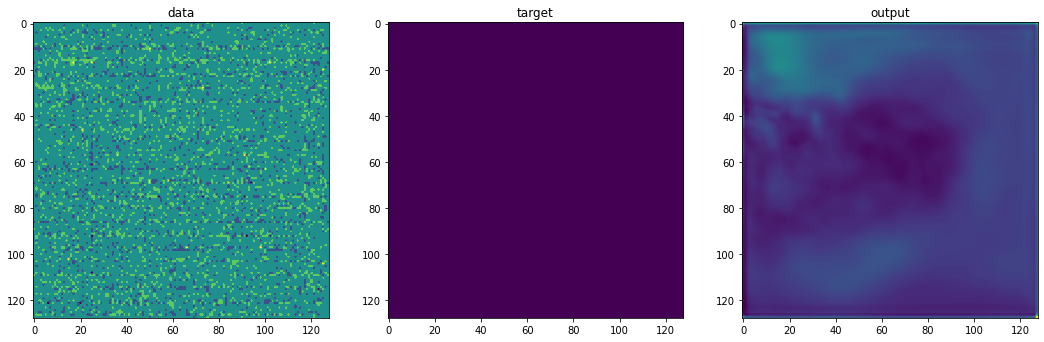

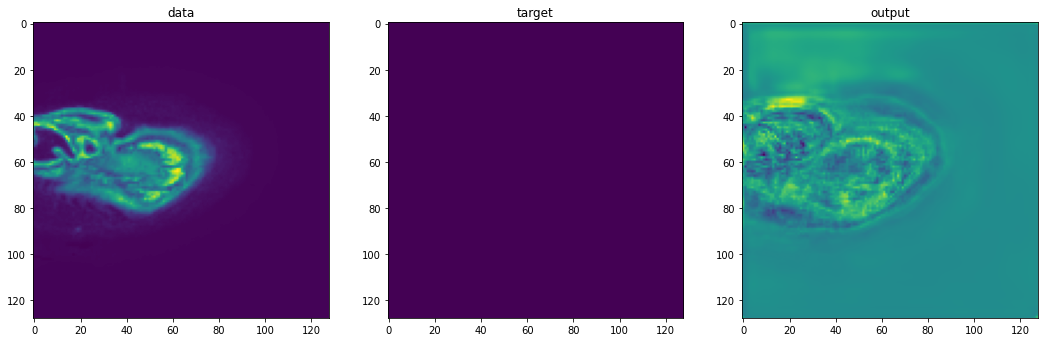

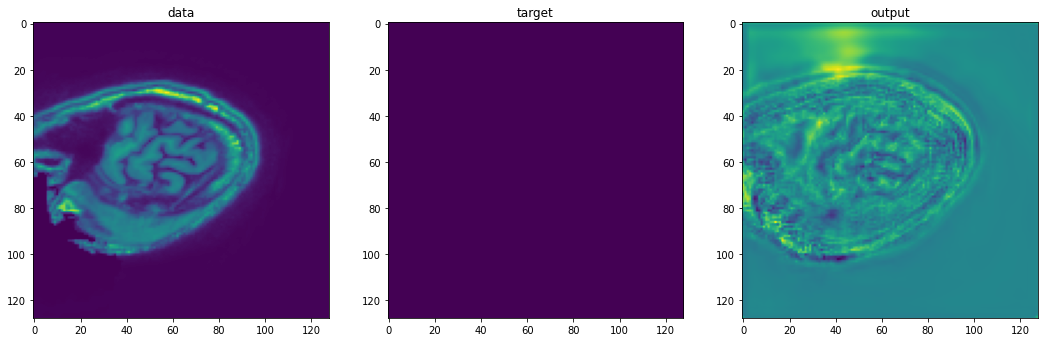

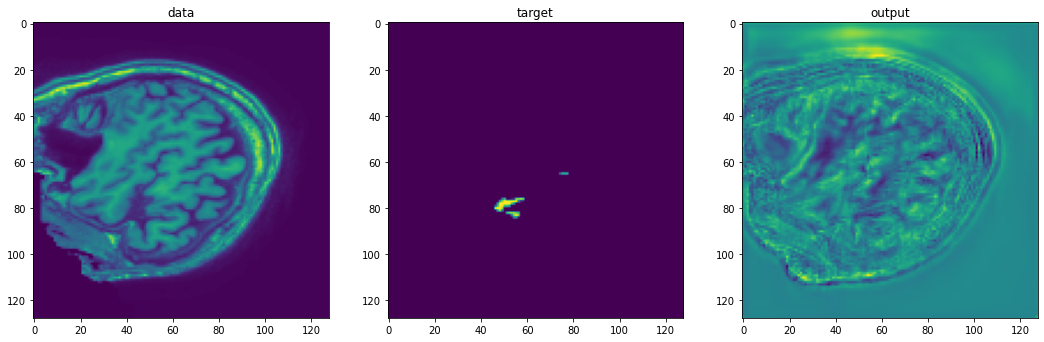

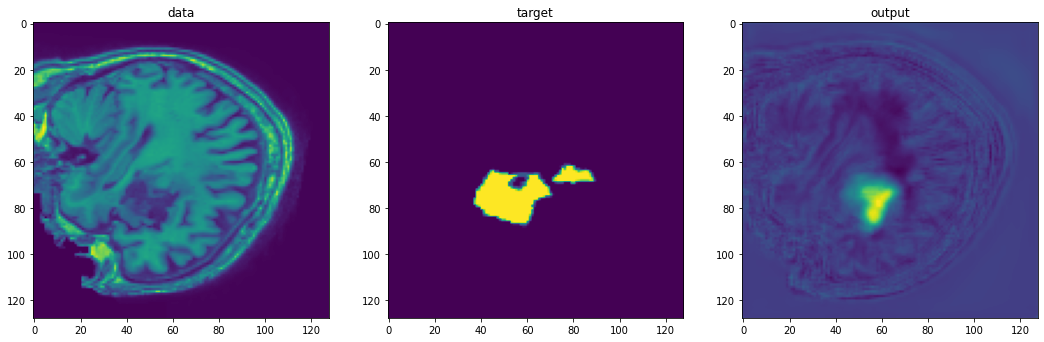

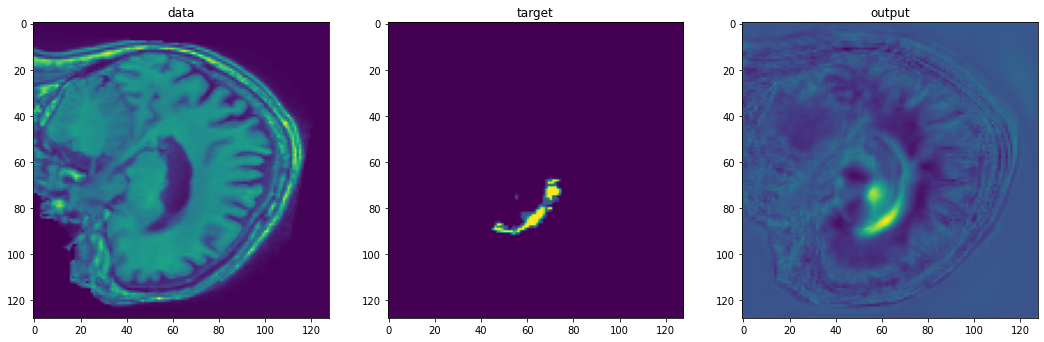

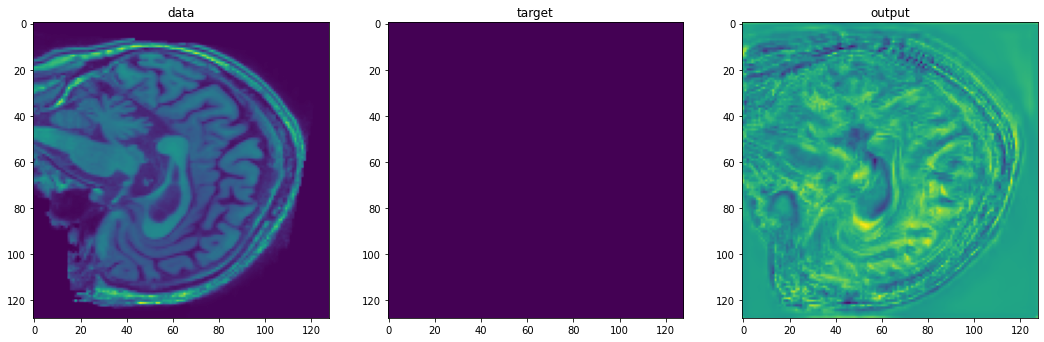

In [ ]:
import matplotlib.pyplot as plt

for i in range(1,64,10):
  plt.figure(figsize=(18, 8)) 
  plt.subplot(131)
  plt.imshow(data[0,0,i]);plt.title('data')
  plt.subplot(132)
  plt.imshow(label[0,0,i]);plt.title('target')
  plt.subplot(133)
  plt.imshow(output[0,0,i]);plt.title('output')

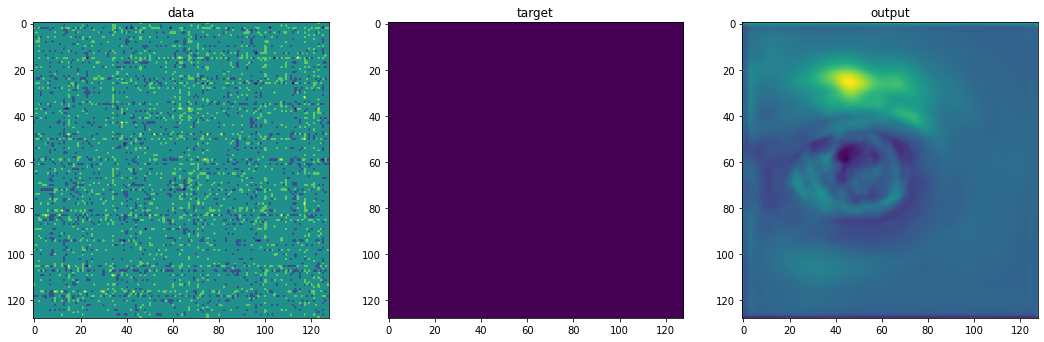

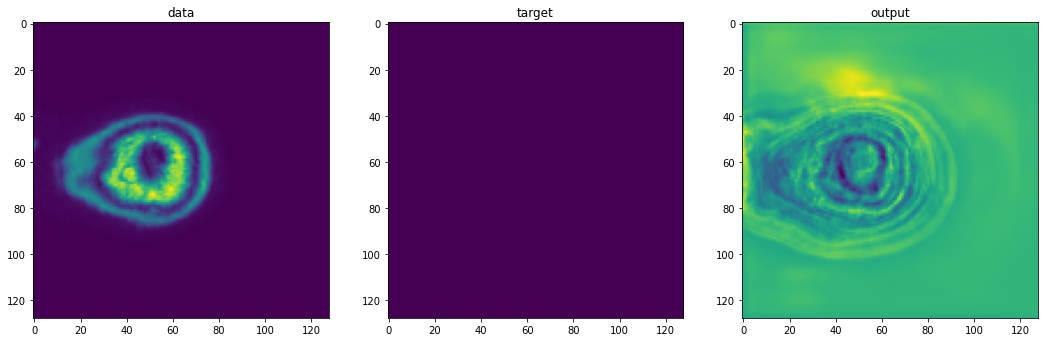

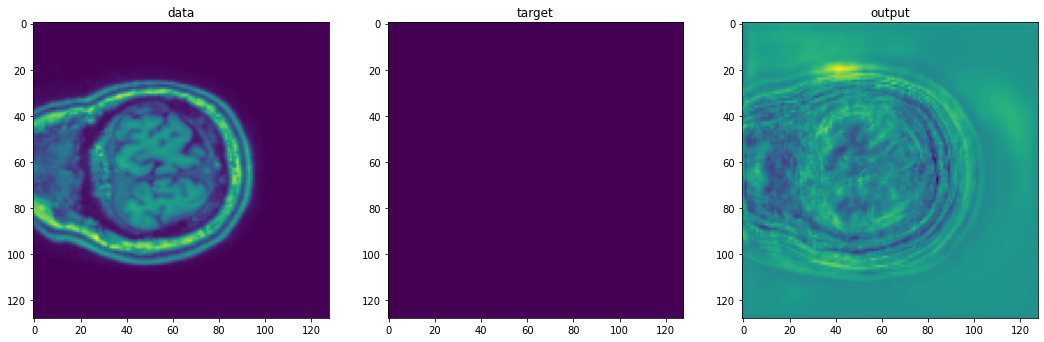

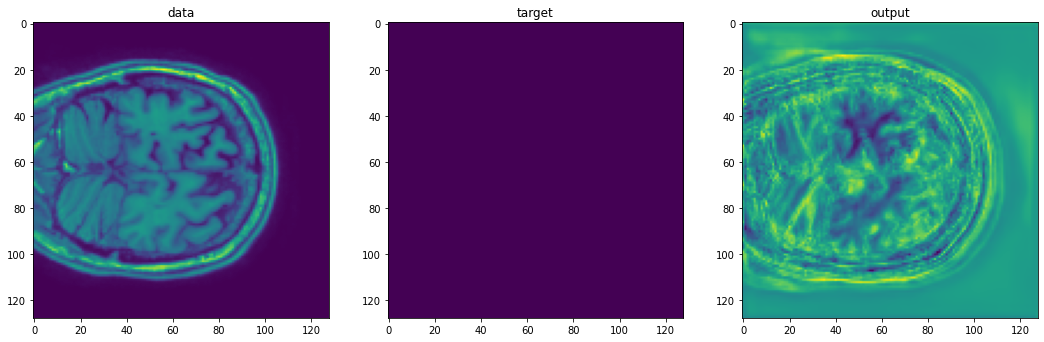

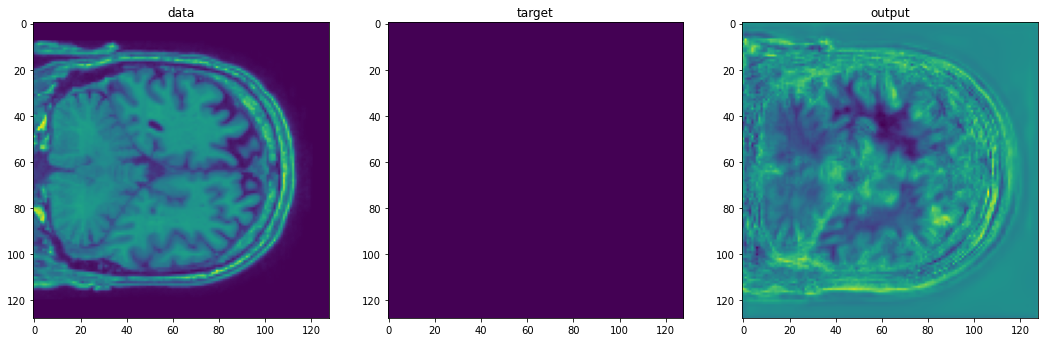

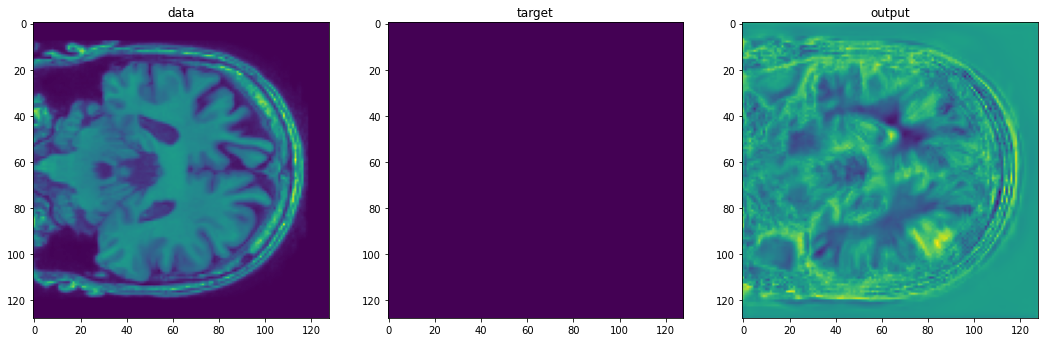

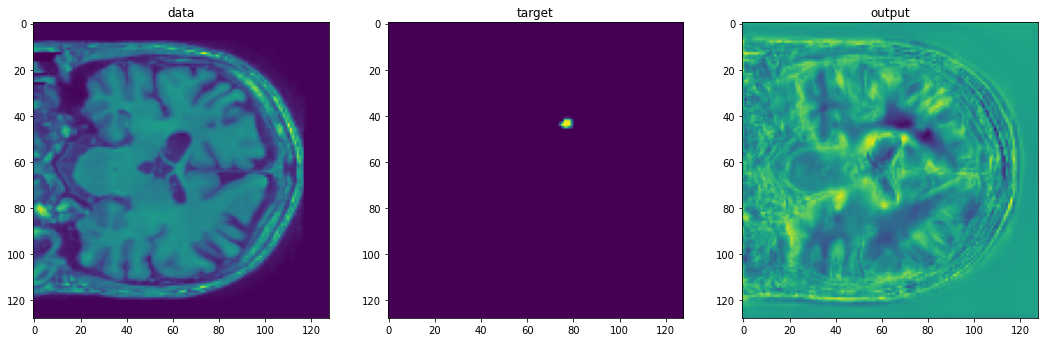

In [ ]:
for i in range(1,64,10):
  plt.figure(figsize=(18, 8)) 
  plt.subplot(131)
  plt.imshow(data[0,0,:,i]);plt.title('data')
  plt.subplot(132)
  plt.imshow(label[0,0,:,i]);plt.title('target')
  plt.subplot(133)
  plt.imshow(output[0,0,:,i]);plt.title('output')

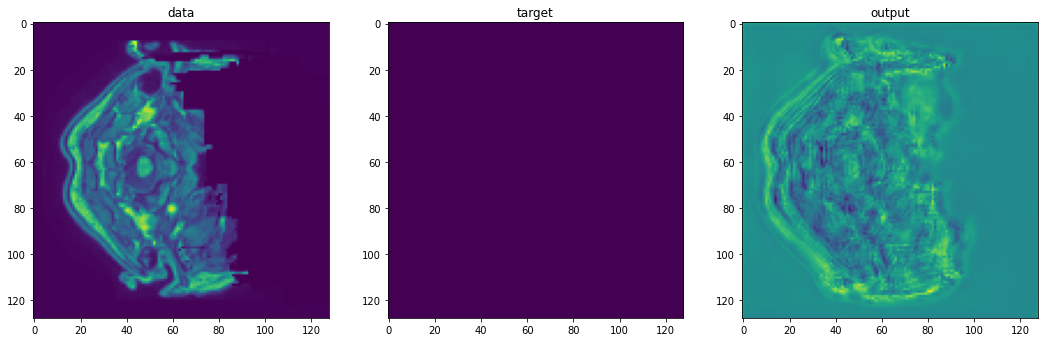

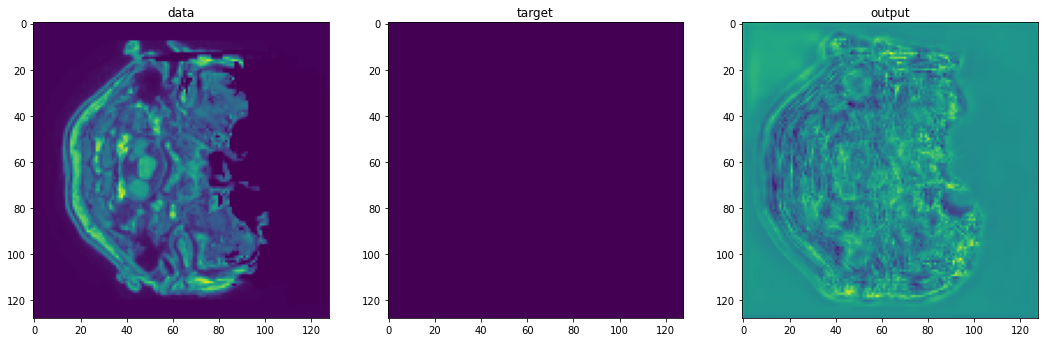

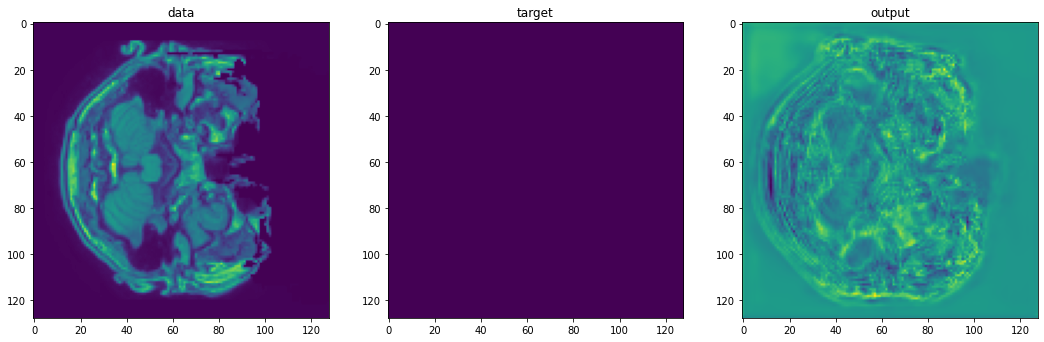

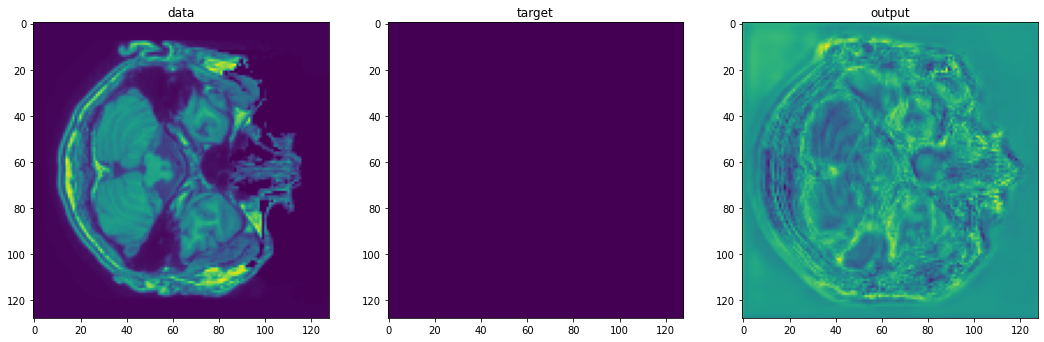

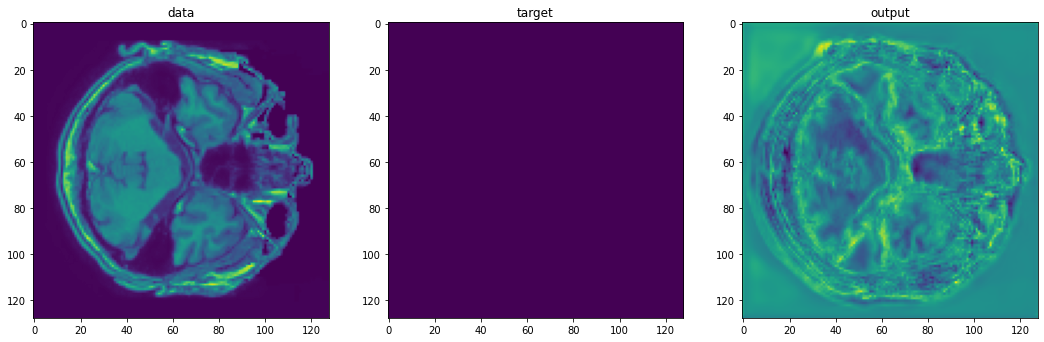

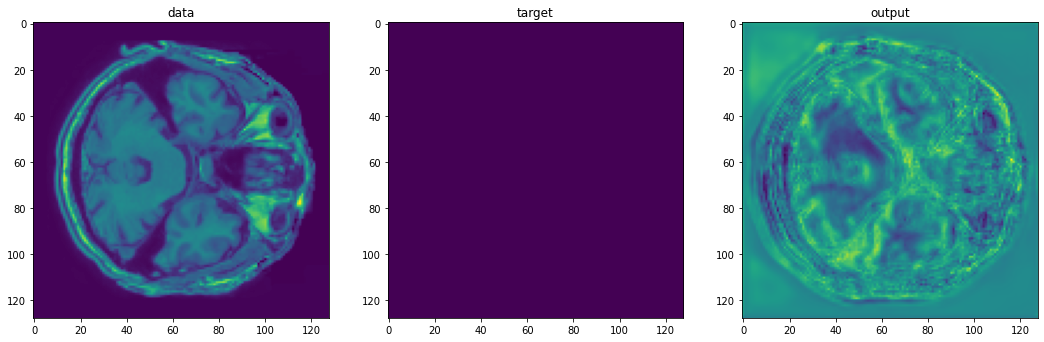

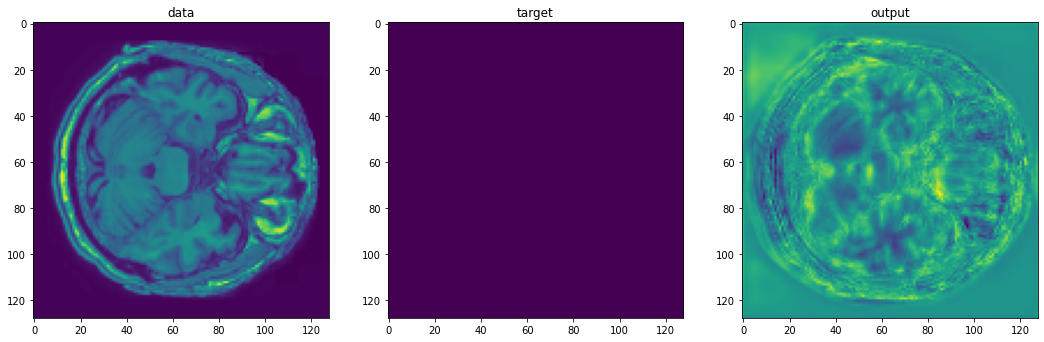

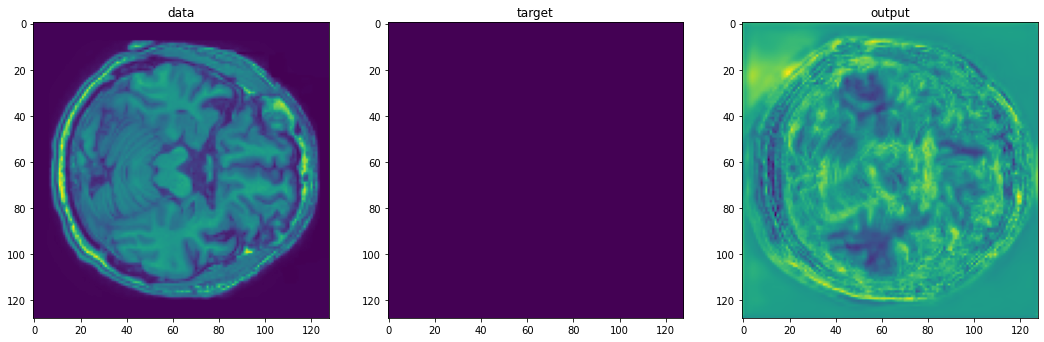

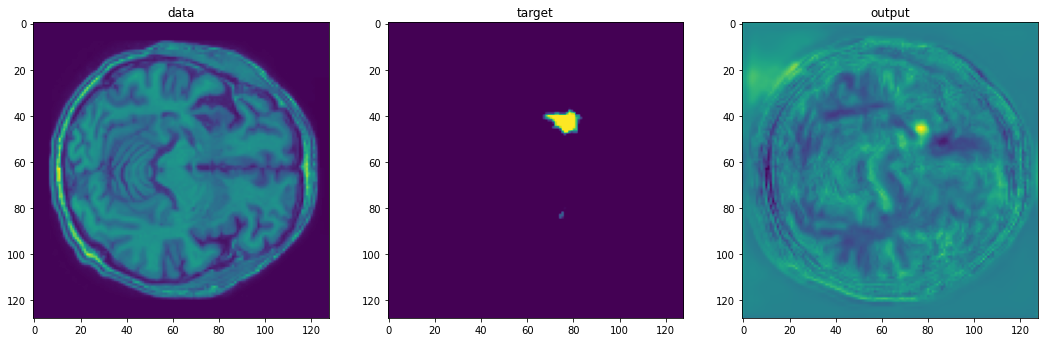

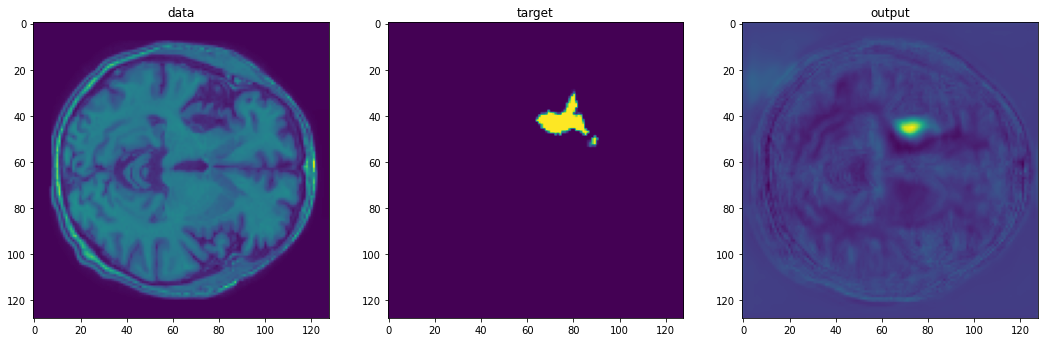

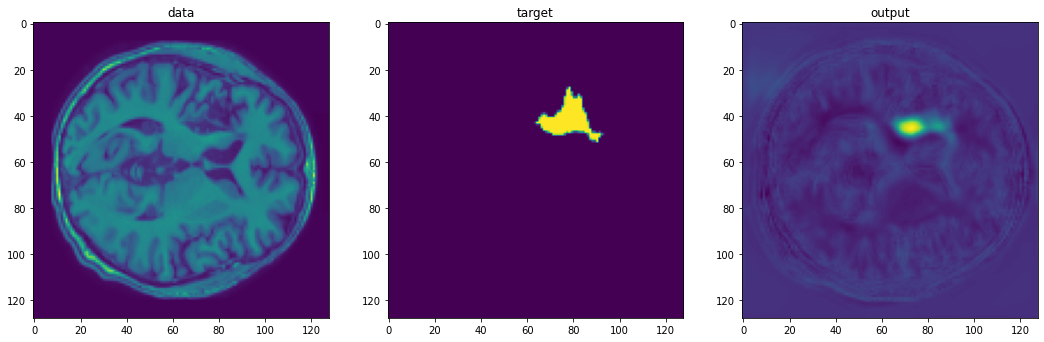

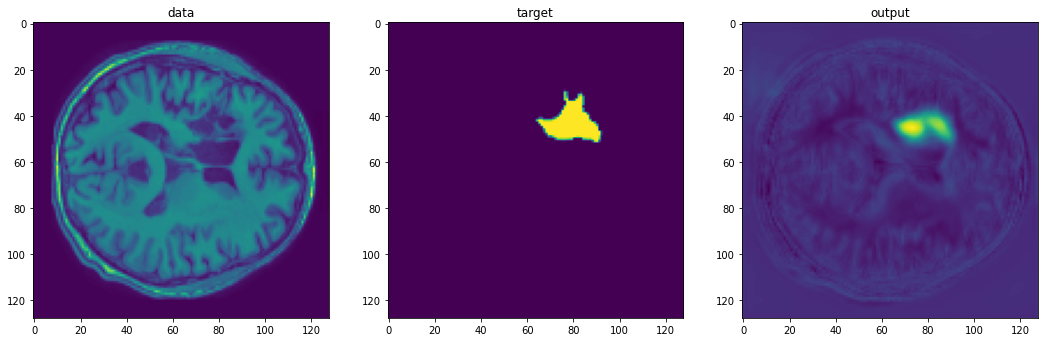

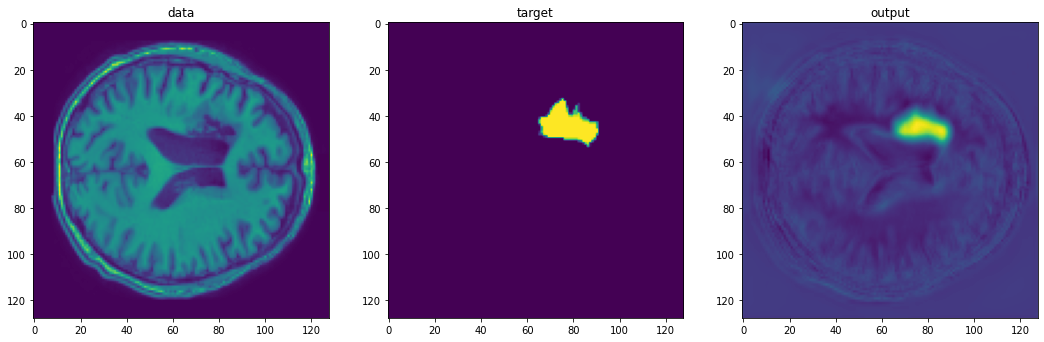

In [ ]:
for i in range(1,64,5):
  plt.figure(figsize=(18, 8)) 
  plt.subplot(131)
  plt.imshow(data[0,0,:,:,i]);plt.title('data')
  plt.subplot(132)
  plt.imshow(label[0,0,:,:,i]);plt.title('target')
  plt.subplot(133)
  plt.imshow(output[0,0,:,:,i]);plt.title('output')